# Lab 12d: Thompson and $\epsilon$-greedy Thompson sampling and the Binary Bandit Problem
This example will familiarize students with variants of [Thompson Sampling](https://arxiv.org/abs/1707.02038) for the solution of Binary Bandit Problems (BBPs), which are particular types of [Multi-arm Bandit problems](https://en.wikipedia.org/wiki/Multi-armed_bandit) where the agent receives a reward of $r\in\left\{0,1\right\}$ for each action tried, where the reward $r$ = `1` indicates that action was successful. In contrast, $r$ = `0` indicates an action $a$ was not successful.

### Scenario
You have a set of possible choices $a\in\mathcal{A}$ that, when implemented, have probabilistic outcomes of `{success | failure}.` The decision agent _does not know the underlying probability distribution_ of `{success | failure}` of each choice $a\in\mathcal{A}$. However, we are the [the Oracle](https://en.wikipedia.org/wiki/The_Oracle_(The_Matrix)). Thus, we know the actual probability distributions.

By experimenting in the world, can the decision-making agent learn the probability of `{success | failure}` of each choice $a\in\mathcal{A}$?

## Setup
We set up the computational environment by including [the `Include. jl` file](Include.jl) using [the `include(...)` method](https://docs.julialang.org/en/v1/base/base/#Base.include). The [`Include.jl` file](Include.jl) loads external packages and functions we will use in these examples. 
* For additional information on functions and types used in this example, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

In [3]:
include("Include.jl");

## Task 1: Setup the world
In this task, we set up the world where our agents make decisions.  Imagine that we have three choices, where the success of each option is governed by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with parameter $\theta_{a}$. Let's build a world dictionary with Bernoulli distributions modeling the ground truth we query to determine the `{success | failure}` of choice $a\in\mathcal{A}$. 

Store this world model in the `world_d_dict::Dict{Int64, Bernoulli}` variable.

In [5]:
world_d_dict, K, number_of_steps, θ_array = let

    # setup some constants -
    number_of_steps = 5000;
    K = 3; # we have three choices
    
    # initialize the world -
    world_d_dict = Dict{Int64, Bernoulli}();
    θ_array = [0.90, 0.60, 0.80]; # values taken from Russo et al Fig. 3.1. aᵢ is the probability of success of choice i
        
    # Hard code the parameters for the Bernoulli distributions; these are the 
    # ground truth, but the agent doesn't know them (and they are NOT directly visible)
    for k ∈ 1:K
        world_d_dict[k] = Bernoulli(θ_array[k]);
    end

    # return
    world_d_dict, K, number_of_steps, θ_array
end;

Next, let's build a `world(...)` function that the agent calls to run experiments in the world. The `world(...)` function encodes the response the agent receives from taking action $a\in\mathcal{A}$. In `BBPs,` this reward is binary $r\in\left\{0,1\right\}$ and governed by a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution).
* The `world(...)` function takes in the action $a\in\mathcal{A}$ chosen by the agent, and the `world_d_dict::Dict{Int64, Bernoulli}` dictionary and returns a reward value `r::Int64`, where `r = 1` indicates that action $a$ was successful, and `r=0` is action $a$ failed.

In [7]:
# Let's build a world function -
function world(action::Int64, dict::Dict{Int64, Bernoulli})::Int64

    # initialize -
    reward = nothing
    
    # grab the distribution from the dict -
    d = dict[action];
    
    value = rand(d);
    value == true ? reward = 1 : reward = 0;

    # return -
    return reward;
end;

## Task 2: Sampling the world
In this task, we let our agent learn which choice is most likely to result in success by experimenting in the world. We consider two approaches: Thompson sampling and $\epsilon$-greed Thompson sampling. For a deeper look at Thompson sampling, check out:

* [Daniel J. Russo, Benjamin Van Roy, Abbas Kazerouni, Ian Osband and Zheng Wen (2018), "A Tutorial on Thompson Sampling", Foundations and Trends in Machine Learning: Vol. 11: No. 1, pp 1-96.  Preprint: https://arxiv.org/abs/1707.02038](https://arxiv.org/abs/1707.02038)

### Thompson Sampling
In Thompson sampling, the agent chooses the greedy action, i.e., the action $a\in\mathcal{A}$ that, up to now, has given the best history of success. We model this approach using [the `ThompsonSamplingModel` type](src/Types.jl). We store this sampling model in the `model` variable.

In [49]:
model = let
    
    model = ThompsonSamplingModel() # build and empty Thompson sample object -
    model.K = K; # how many choices do we have?
    model.α = ones(K); # initialize to uniform values
    model.β = ones(K); # initialize to uniform values

    # return
    model;
end;

To sample the world, we pass the sampling model instance `model::ThompsonSamplingModel,` a `world(...)` function, and the number of steps (the `horizon` of the game) to [the `sample` function](src/Bandits.jl). 
* The [`sample(...)` function](src/Bandits.jl) returns a dictionary of time sample results; we store these results in the `time_sample_results_dict_Ts::Dict{Int64, Matrix{Float64}}` dictionary. The keys of this dictionary are the indexes of the game rounds, while the values are the $\alpha,\beta$ values of each possible choice; these are the parameters of the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution).

In [11]:
# build the world function, and sample it 
world_function(a) = world(a, world_d_dict);
time_sample_results_dict_Ts = sample(model; 𝒯 = number_of_steps, world=world_function)

Dict{Int64, Matrix{Float64}} with 5000 entries:
  4986 => [4382.0 509.0; 7.0 5.0; 68.0 20.0]
  4700 => [4124.0 484.0; 5.0 5.0; 67.0 20.0]
  4576 => [4006.0 478.0; 5.0 5.0; 67.0 20.0]
  2288 => [1962.0 238.0; 4.0 5.0; 65.0 19.0]
  1703 => [1426.0 192.0; 3.0 4.0; 64.0 19.0]
  1956 => [1655.0 214.0; 4.0 4.0; 65.0 19.0]
  2350 => [2015.0 247.0; 4.0 5.0; 65.0 19.0]
  3406 => [2958.0 359.0; 4.0 5.0; 66.0 19.0]
  2841 => [2453.0 300.0; 4.0 5.0; 65.0 19.0]
  2876 => [2484.0 304.0; 4.0 5.0; 65.0 19.0]
  687  => [552.0 76.0; 2.0 4.0; 47.0 11.0]
  185  => [153.0 19.0; 2.0 4.0; 9.0 3.0]
  1090 => [896.0 118.0; 2.0 4.0; 60.0 15.0]
  2015 => [1711.0 217.0; 4.0 4.0; 65.0 19.0]
  3293 => [2857.0 347.0; 4.0 5.0; 66.0 19.0]
  1704 => [1427.0 192.0; 3.0 4.0; 64.0 19.0]
  3220 => [2792.0 339.0; 4.0 5.0; 66.0 19.0]
  4888 => [4290.0 504.0; 6.0 5.0; 68.0 20.0]
  422  => [354.0 45.0; 2.0 4.0; 17.0 5.0]
  1266 => [1055.0 132.0; 2.0 4.0; 62.0 16.0]
  183  => [152.0 18.0; 2.0 4.0; 9.0 3.0]
  1823 => [1535.0 202

Let's look at a particular round of learning for purely Thompson sampling:
* The $\alpha$ parameter describes the number of success observed, while $\beta$ describes the number failures observed for each action. In other words, we are recording the wins and losses of each round in a $|\mathcal{A}|\times{2}$ array, where the first column holds the $\alpha$ values, the second column holds the $\beta$ values and each row corresponds to an action.

In [13]:
time_sample_results_dict_Ts[5000]

3×2 Matrix{Float64}:
 4395.0  510.0
    7.0    5.0
   68.0   20.0

## $\epsilon$-Greedy Thompson Sampling
Unlike Thompson sampling, $\epsilon$-Greedy Thompson Sampling sometimes chooses random actions along with the best action identified so far. When agents choose a random action, they are `exploring` the world. On the other hand, when selecting the best action so far, they are `exploiting` their knowledge of the world gained through experience 
* We build an instance of `EpsilonSamplingModel,` which is similar to `ThompsonSamplingModel` type __except__ now we have an `ϵ` parameter which specifies the fraction of random actions the agent chooses. We save the `EpsilonSamplingModel` instance in the `epsilon_model` variable

In [15]:
epsilon_model = let 
    # Build an epsilon sample object -
    epsilon_model = EpsilonSamplingModel();
    epsilon_model.K = K;
    epsilon_model.α = ones(K); # initialize to uniform values
    epsilon_model.β = ones(K); # initialize to uniform values
    epsilon_model.ϵ = 0.20; # some fraction of the iterations, do a random step

    # return
    epsilon_model
end

EpsilonSamplingModel([1.0, 1.0, 1.0], [1.0, 1.0, 1.0], 3, 0.2)

To sample the world, we pass the sampling model instance `epsilon_model::EpsilonSamplingModel,` a `world(...)` function, and the number of steps (the `horizon` of the game) to [the `sample(...)` function](src/Bandits.jl). 
* The [`sample(...)` function](src/Bandits.jl) returns a dictionary of time sample results; we store these results in the `time_sample_results_dict_eps::Dict{Int64, Matrix{Float64}}` variable. The keys of the dictionary are the indexes of the game rounds, while the values are the $\alpha,\beta$ values for the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) (same data structure as before).

In [17]:
time_sample_results_dict_eps = sample(epsilon_model; 𝒯 = number_of_steps, world=world_function);

Let's look at a particular round of learning for $\epsilon$-Greedy Thompson sampling:

In [19]:
time_sample_results_dict_eps[5000]

3×2 Matrix{Float64}:
 3817.0  431.0
  193.0  152.0
  338.0   74.0

## Task 3: Visualize the results of the two sampling approaches
In this task, we compare the results of the two sampling approaches. We expect our agent to learn which action $a\in\mathcal{A}$ will likely give the highest probability of success. We'll compare what the agent thinks, with the ground truth (that only we know).

* Let's build a table that shows the actual value of the reward probability $\theta$, along with the expected values obtained from Thompson sampling or $\epsilon$-Greedy Thompson sampling. Later, we'll plot the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) associated with each action. 

Specify an index to look at in the `T_index` variable first:

In [62]:
T_index = 1000; # pick a time step to explore

`Unhide` the code block below to see how we use the [PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl) to display the true and expected parameter values

In [64]:
# build the array of beta distributions -
beta_array_Ts = build_beta_array(time_sample_results_dict_Ts[T_index]);
beta_array_eps = build_beta_array(time_sample_results_dict_eps[T_index]);

# initialize -
action_probability_array = Array{Any,2}(undef, K, 4);
for i ∈ 1:K
    
    action_probability_array[i,1] = i;
    action_probability_array[i,2] = θ_array[i];
    
    # get the d -
    d_Ts = beta_array_Ts[i];
    d_eps = beta_array_eps[i];
    
    # grab the parameters from distributions -
    # Thompson sampling -
    αᵢ,βᵢ = params(d_Ts);
    action_probability_array[i,3] = αᵢ/(αᵢ + βᵢ);
    
    # eps-TS -
    αᵢ,βᵢ = params(d_eps);
    action_probability_array[i,4] = αᵢ/(αᵢ + βᵢ);
end

# header -
action_table_header = (["Action aᵢ", "θᵢ", "θ̂ᵢ Ts", "θ̂ᵢ eps-Ts"]);

# display table -
pretty_table(action_probability_array; header = action_table_header)

┌───────────┬─────┬──────────┬───────────┐
│ Action aᵢ │  θᵢ │    θ̂ᵢ Ts │ θ̂ᵢ eps-Ts │
├───────────┼─────┼──────────┼───────────┤
│         1 │ 0.9 │ 0.881847 │   0.89951 │
│         2 │ 0.6 │ 0.333333 │  0.539474 │
│         3 │ 0.8 │ 0.794118 │  0.823009 │
└───────────┴─────┴──────────┴───────────┘


`Unhide` the code block below to see how we plot the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) for each action $a\in\mathcal{A}$ obtained from Thompson sampling after `T` game rounds:

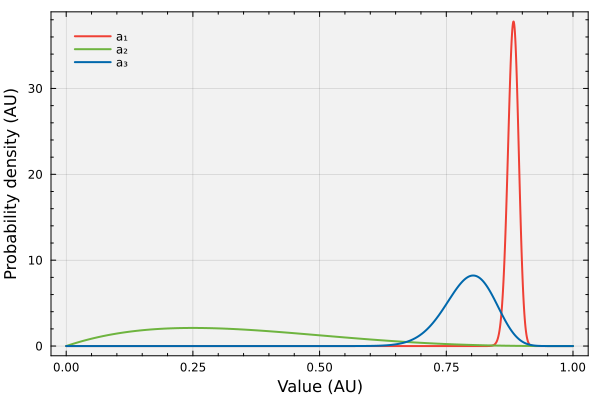

In [66]:
# get the distributions for this time point -
plot(beta_array_Ts[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_Ts[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_Ts[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)

`Unhide` the code block below to see how we plot the [Beta distributions](https://en.wikipedia.org/wiki/Beta_distribution) for each action $a\in\mathcal{A}$ obtained from $\epsilon$-Greedy Thompson sampling after `T` game rounds:

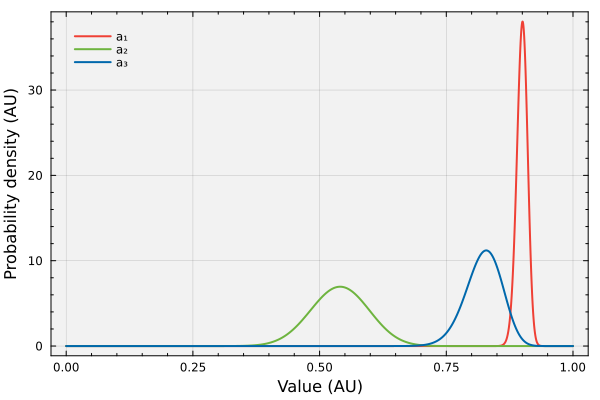

In [68]:
 # get the distributions for this time point -
plot(beta_array_eps[1], legend=:topleft, label="a₁", lw=2, bg=colorant"#F2F2F2", 
    background_color_outside="white", framestyle = :box, fg_legend = :transparent, minorticks=0.05, 
    c=colorant"#EF4035")
plot!(beta_array_eps[2], label="a₂", lw=2, c=colorant"#6EB43F")
plot!(beta_array_eps[3], label="a₃", lw=2, c=colorant"#0068AC")

# setup labels -
xlabel!("Value (AU)", fontsize=18)
ylabel!("Probability density (AU)", fontsize=18)